## Implementation of a convnets autoencoder using TensorFlow backend and Keras
### Author: Tuan Le
### Email: tuanle@hotmail.de

In this case we will use the Zalando FASHION MNIST dataset. The dataset will be loaded from `tensorflow.keras.datasets` module via the Python API directly.

C:\Users\tuanl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Minimum value in matrix X: 0
Maximum value in matrix X: 255
Now scaling into range (0,1)
Minimum value in matrix X: 0
Maximum value in matrix X: 255


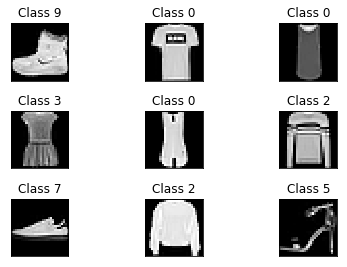

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(x_train, y_train), (x_test, y_test)= tf.keras.datasets.fashion_mnist.load_data()

### Show first 9 images of dataset:
# Plot images
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Class {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

### Scale X such that training can be done more efficiently:
print("Minimum value in matrix X:", np.min(x_train))
print("Maximum value in matrix X:", np.max(x_train))
print("Now scaling into range (0,1)")
print("Minimum value in matrix X:", np.min(x_train))
print("Maximum value in matrix X:", np.max(x_train))
input_shape = (x_train.shape[1], x_train.shape[2], 1)
## Preprocess 
x_train = x_train.astype('float32') / np.max(x_train)
x_test = x_test.astype('float32') / np.max(x_test)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

### Now define the architecture for the CNN autoencoder

In [2]:
## Import keras modules for defining architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D

conv_autoencoder = Sequential()

##### Encoder Part #####
print("Definining encoder part of cnn autoencoder:")
#### 1. Convolutional Layer with relu####
conv_autoencoder.add(Conv2D(32, (3, 3),
                            padding='same', input_shape=input_shape,
                            activation='relu', name='enc_conv_layer_1_relu'))

## Add BatchNormalization
conv_autoencoder.add(BatchNormalization(name='enc_batch_normal_layer_1'))
## Add MaxPooling to shrink dimension
conv_autoencoder.add(MaxPooling2D((2,2), padding='same', name='enc_max_pooling_layer_1'))

#### 2. Covolutional Layer with kernel initializer and lecun_normal activation ####
conv_autoencoder.add(Conv2D(16, (3, 3),
                            activation='selu', padding='same',
                            kernel_initializer='lecun_normal', name='enc_conv_layer_2_selu'))
## Add Maxpooling to shrink dimension
conv_autoencoder.add(MaxPooling2D((2,2), padding='same', name='enc_max_pooling_layer_2'))

#### 3. Convolutional Layer with kernel initializer and softplus activation ####
conv_autoencoder.add(Conv2D(8, (3, 3),
                            activation='softplus', padding='same',
                            kernel_initializer='RandomNormal', name='enc_conv_layer_3_softplus'))

conv_autoencoder.add(BatchNormalization(name='enc_batch_normal_layer_3'))
## Add Maxpooling as last dimension shrinkage for the encoder part
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same', name='max_pooling_layer_3'))

print("Convolutional Neural Net Encoder Part:")
print(conv_autoencoder.summary())
print("The output shape of the encoder part is:", conv_autoencoder.output_shape)
print("Flatten version has",
      conv_autoencoder.output_shape[1]*conv_autoencoder.output_shape[2]*conv_autoencoder.output_shape[3], "entries.")

##### Decoder Part #####
print("Definining decoder part of cnn autoencoder:")

#### 4. Convolutional Layer with relu activation ####
conv_autoencoder.add(Conv2D(8, (3, 3),
                            activation='relu', padding='same',
                            kernel_initializer='lecun_normal', name='dec_conv_layer_4_relu'))
conv_autoencoder.add(BatchNormalization(name='dec_batch_normal_layer_4'))
#### Add deconvolution or rather transposed convolution
conv_autoencoder.add(UpSampling2D((2, 2), name='dec_upsample_conv_layer4'))

#### 5. Convolutional Layer with relu activation ####
conv_autoencoder.add(Conv2D(16, (3, 3),
                            activation='relu', padding='same',
                            kernel_initializer='lecun_normal', name='dec_conv_layer_5_relu'))
conv_autoencoder.add(BatchNormalization(name='dec_batch_normal_layer_5'))
#### Add deconvolution or rather transposed convolution
conv_autoencoder.add(UpSampling2D((2, 2), name='dec_upsample_conv_layer5'))

#### 6. Convolutional Layer with relu activation ####
conv_autoencoder.add(Conv2D(32, (3, 3),
                            activation='relu', padding='valid',
                            kernel_initializer='lecun_normal', name='dec_conv_layer_6_relu'))
conv_autoencoder.add(BatchNormalization(name='dec_batch_normal_layer_6'))
#### Add deconvolution or rather transposed convolution
conv_autoencoder.add(UpSampling2D((2, 2), name='dec_upsample_conv_layer6'))

#### 7. Convolutional Layer with relu activation as decoder part, hence number of filters only 1####
conv_autoencoder.add(Conv2D(1, (3, 3),
                            activation='sigmoid', padding='same',
                            kernel_initializer='lecun_normal', name='dec_conv_layer_7_relu'))

print(conv_autoencoder.summary())

Using TensorFlow backend.


Definining encoder part of cnn autoencoder:
Convolutional Neural Net Encoder Part:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv_layer_1_relu (Conv2 (None, 28, 28, 32)        320       
_________________________________________________________________
enc_batch_normal_layer_1 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
enc_max_pooling_layer_1 (Max (None, 14, 14, 32)        0         
_________________________________________________________________
enc_conv_layer_2_selu (Conv2 (None, 14, 14, 16)        4624      
_________________________________________________________________
enc_max_pooling_layer_2 (Max (None, 7, 7, 16)          0         
_________________________________________________________________
enc_conv_layer_3_softplus (C (None, 7, 7, 8)           1160      
___________________________________________________________

### Now we train the model and save the call back history on local machine

In [3]:
import os
print(os.getcwd())

C:\Users\tuanl\Desktop\DeepLearning_AutoEncoders


In [4]:
from keras.losses import binary_crossentropy
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

conv_autoencoder.compile(
            loss = binary_crossentropy,
            optimizer = adam(lr = 1e-3),
            metrics = ['accuracy']
        )
callbacks = [
            ModelCheckpoint(filepath = 'cnn_autencoder.hdf5', monitor = 'val_acc',
                save_best_only = True, verbose=1, mode = 'max')
            ]

import datetime
start_train = datetime.datetime.now()
history = conv_autoencoder.fit(
            x=x_train, y=x_train,
            epochs=50,
            batch_size=256,
            shuffle=True,
            validation_data=(x_test, x_test),
            callbacks = callbacks
        )
end_train = datetime.datetime.now()
time_train = end_train - start_train
print("Training took:", time_train)

# model performance
train_results = conv_autoencoder.evaluate(x_train, x_train)
test_results = conv_autoencoder.evaluate(x_test, x_test)
print("Train       Loss: ", train_results[0])
print("Train       Acc: ",  train_results[1])
print("Validation  Loss:",  test_results[0])
print("Validation  Acc: ",  test_results[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 14s 239us/step - loss: 0.3753 - acc: 0.4934 - val_loss: 0.3624 - val_acc: 0.4942

Epoch 00001: val_acc improved from -inf to 0.49415, saving model to cnn_autencoder.hdf5
Epoch 2/50
60000/60000 [==============================] - 12s 200us/step - loss: 0.3004 - acc: 0.5053 - val_loss: 0.3269 - val_acc: 0.4986

Epoch 00002: val_acc improved from 0.49415 to 0.49863, saving model to cnn_autencoder.hdf5
Epoch 3/50
60000/60000 [==============================] - 12s 201us/step - loss: 0.2924 - acc: 0.5061 - val_loss: 0.3092 - val_acc: 0.5002

Epoch 00003: val_acc improved from 0.49863 to 0.50018, saving model to cnn_autencoder.hdf5
Epoch 4/50
60000/60000 [==============================] - 12s 201us/step - loss: 0.2883 - acc: 0.5065 - val_loss: 0.2976 - val_acc: 0.5024

Epoch 00004: val_acc improved from 0.50018 to 0.50242, saving model to cnn_autencoder.hdf5
Epoch 5/50
60000/60000 [=====

60000/60000 [==============================] - 12s 201us/step - loss: 0.2707 - acc: 0.5085 - val_loss: 0.2734 - val_acc: 0.5061

Epoch 00041: val_acc did not improve from 0.50655
Epoch 42/50
60000/60000 [==============================] - 12s 202us/step - loss: 0.2710 - acc: 0.5085 - val_loss: 0.2753 - val_acc: 0.5057

Epoch 00042: val_acc did not improve from 0.50655
Epoch 43/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.2708 - acc: 0.5085 - val_loss: 0.2724 - val_acc: 0.5064

Epoch 00043: val_acc did not improve from 0.50655
Epoch 44/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.2705 - acc: 0.5086 - val_loss: 0.2722 - val_acc: 0.5063

Epoch 00044: val_acc did not improve from 0.50655
Epoch 45/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.2704 - acc: 0.5086 - val_loss: 0.2725 - val_acc: 0.5062

Epoch 00045: val_acc did not improve from 0.50655
Epoch 46/50
60000/60000 [==============================] 

In [5]:
## Predict test images to get reconstruction
decoded_images = conv_autoencoder.predict(x_test)

First 9 images from test data


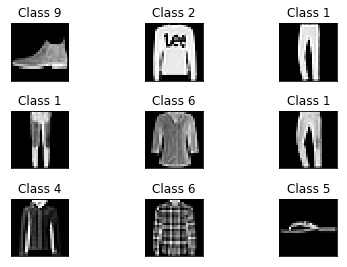

In [6]:
print("First 9 images from test data")
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_test[i].reshape(28, 28), cmap='gray', interpolation='none')
  plt.title("Class {}".format(y_test[i]))
  plt.xticks([])
  plt.yticks([])

Corresponding reconstructed 9 test images


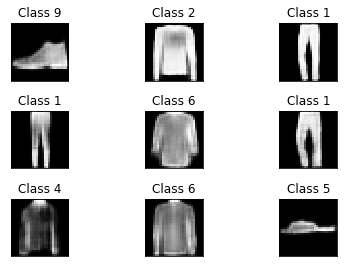

In [7]:
print("Corresponding reconstructed 9 test images")    
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(decoded_images[i].reshape(28, 28), cmap='gray', interpolation='none')
  plt.title("Class {}".format(y_test[i]))
  plt.xticks([])
  plt.yticks([])

## Comments
As can be seen the reconstruction is rather bad. For example the second image in the first row is not properly reconstructed and has the 'LEE' brand. Further improvements would be to create larger CNNs (in terms of number of filters/depth)  
in the encoder and decoder part in order to better fetch the features. 

In [8]:
## END